In [1]:
import collections

import numpy as np

collections.Iterable = collections.abc.Iterable
from prepare_model_env import *

In [2]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import keras

In [4]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
with tf.device("/GPU:0"):
    import rasterio as rio
    test_mask_dir = "../../datasets/marine_debris_detection/marine_debris-semantic_segmentation/test/labels/"
    test_images_dir = "../../datasets/marine_debris_detection/marine_debris-semantic_segmentation/test/images/"
    ## checking predictions on new unannotated images
    test_images = []
    test_masks = []
    for filename in os.listdir(test_images_dir):
        image_path = os.path.join(test_images_dir, filename)
        test_images.append(io.imread(image_path))
        mask_path = os.path.join(test_mask_dir, filename.split('.')[0]+"_marineDebris.ome.tiff")
        with rio.open(mask_path) as mask :
            masknp = mask.read()
        test_masks.append(np.where(masknp[0] > 0, 1, masknp[0]))

D:\anaconda\envs\segmentation_gpu\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [6]:
n_classes = 1
activation = 'sigmoid'

#model_efficientnetb3 = sm.Unet("efficientnetb3", classes=n_classes, activation=activation)
model_efficientnetb4 = sm.Unet("efficientnetb4", classes=n_classes, activation=activation)
model_efficientnetb4_v2 = sm.Unet("efficientnetb4", classes=n_classes, activation=activation)
model_efficientnetb4_v3 = sm.Unet("efficientnetb4", classes=n_classes, activation=activation)
#model_resnet50 = sm.Unet("resnet50", classes=n_classes, activation=activation)
#model_inceptionresnetv2 = sm.Unet("inceptionresnetv2", classes=n_classes, activation=activation)
#model_vgg19 = sm.Unet("vgg19", classes=n_classes, activation=activation)

In [7]:
# dice loss = 1 - (2 * intersection) / (union + intersection)
dice_loss = sm.losses.DiceLoss()
# Binary Focal Loss = -α * (1 - p)^γ * log(p) - (1 - α) * p^γ * log(1 - p)
# α is a weighting factor to balance the contribution of the two classes. It is typically set to the inverse of the class frequencies.
# p is the predicted probability of the positive class.
# γ is the focusing parameter that controls how much the loss is focused on hard examples.
# When γ = 0, the focal loss becomes the standard binary cross-entropy loss. As γ increases,
# the loss focuses more on hard examples, i.e., examples that are misclassified with high confidence.
focal_loss = sm.losses.BinaryFocalLoss(gamma=2.5, alpha=0.3)

total_loss = dice_loss + 1.5*focal_loss

metrics = [sm.metrics.IOUScore(threshold=0.5)]

# compile keras models with defined optimozer, loss and metrics
#model_efficientnetb3.compile(optimizer='Adam', loss=total_loss, metrics=metrics)
model_efficientnetb4.compile(optimizer='Adam', loss=total_loss, metrics=metrics)
model_efficientnetb4_v2.compile(optimizer='Adam', loss=total_loss, metrics=metrics)
model_efficientnetb4_v3.compile(optimizer='Adam', loss=total_loss, metrics=metrics)
#model_resnet50.compile(optimizer='Adam', loss=total_loss, metrics=metrics)
#model_inceptionresnetv2.compile(optimizer='Adam', loss=total_loss, metrics=metrics)
#model_vgg19.compile(optimizer='Adam', loss=total_loss, metrics=metrics)

In [13]:
# load models weights
# model_efficientnetb3.load_weights("best_model_efficientnetb3_1.h5")
model_efficientnetb4.load_weights("best_model_efficientnetb4_1.h5")
model_efficientnetb4_v2.load_weights("best_model_efficientnetb4_2.h5")
model_efficientnetb4_v3.load_weights("best_model_efficientnetb4_3.h5")
# model_resnet50.load_weights("best_model_resnet50_1.h5")
# model_inceptionresnetv2.load_weights("best_model_inceptionresnetv2_1.h5")
# model_vgg19.load_weights("best_model_vgg19_1.h5")

In [14]:
# pre process input and masks
test_images = np.array(test_images)
test_masks = np.array(test_masks)
test_masks = tf.cast(test_masks, tf.float32)

In [15]:
tf.config.run_functions_eagerly(True)

In [16]:
# test models
# efficientnetb3_results = model_efficientnetb3.evaluate(test_images, test_masks)
# print("efficientnetb3: loss={}, IOU score={}".format(efficientnetb3_results[0], efficientnetb3_results[1]))
efficientnetb4_results = model_efficientnetb4.evaluate(test_images, test_masks)
print("efficientnetb4: loss={}, IOU score={}".format(efficientnetb4_results[0], efficientnetb4_results[1]))
efficientnetb4_v2_results = model_efficientnetb4_v2.evaluate(test_images, test_masks)
print("efficientnetb4_v2: loss={}, IOU score={}".format(efficientnetb4_v2_results[0], efficientnetb4_v2_results[1]))
efficientnetb4_v3_results = model_efficientnetb4_v3.evaluate(test_images, test_masks)
print("efficientnetb4: loss={}, IOU score={}".format(efficientnetb4_v3_results[0], efficientnetb4_v3_results[1]))
# resnet50_results = model_resnet50.evaluate(test_images, test_masks)
# print("resnet50: loss={}, IOU score={}".format(resnet50_results[0], resnet50_results[1]))
# inceptionresnetv2_results = model_inceptionresnetv2.evaluate(test_images, test_masks)
# print("inceptionresnetv2: loss={}, IOU score={}".format(inceptionresnetv2_results[0], inceptionresnetv2_results[1]))
# vgg19_results = model_vgg19.evaluate(test_images, test_masks)
# print("vgg19: loss={}, IOU score={}".format(vgg19_results[0], vgg19_results[1]))

2/2 [==============================] - 1s 421ms/step - loss: 0.3285 - iou_score: 0.5528
efficientnetb4: loss=0.32846397161483765, IOU score=0.5527517199516296
2/2 [==============================] - 1s 277ms/step - loss: 0.2977 - iou_score: 0.5779
efficientnetb4_v2: loss=0.29773974418640137, IOU score=0.5779452919960022
2/2 [==============================] - 1s 279ms/step - loss: 0.3175 - iou_score: 0.5649
efficientnetb4: loss=0.3174813389778137, IOU score=0.5649008750915527


1/1 [==============================] - 1s 932ms/step


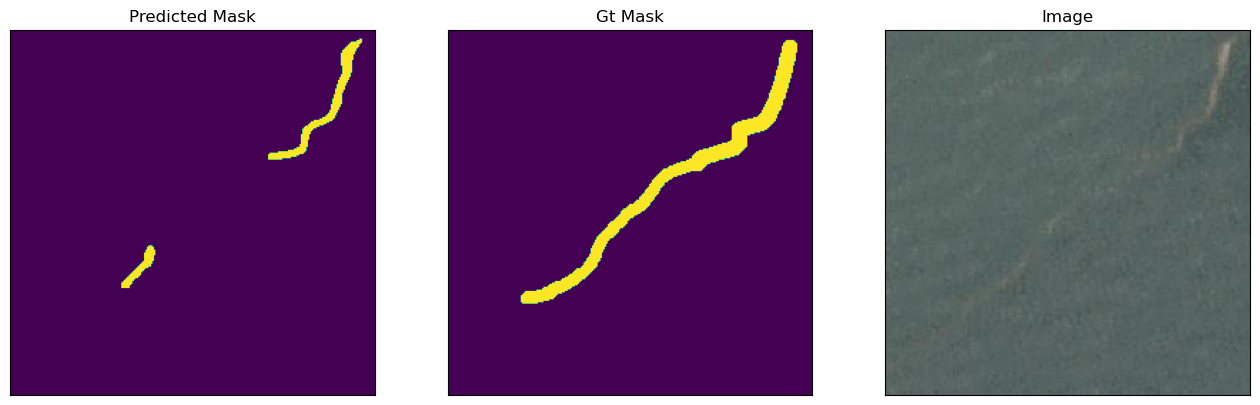

1/1 [==============================] - 0s 249ms/step


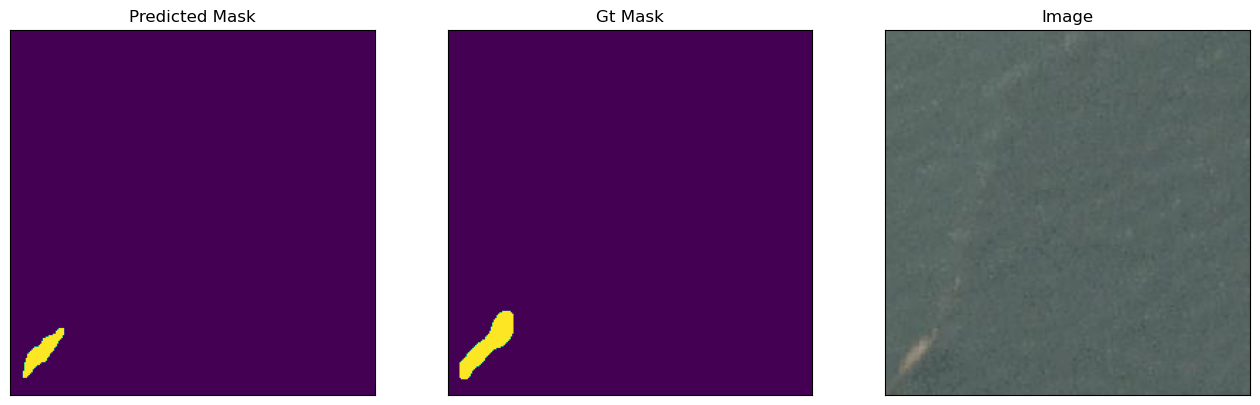

1/1 [==============================] - 0s 231ms/step


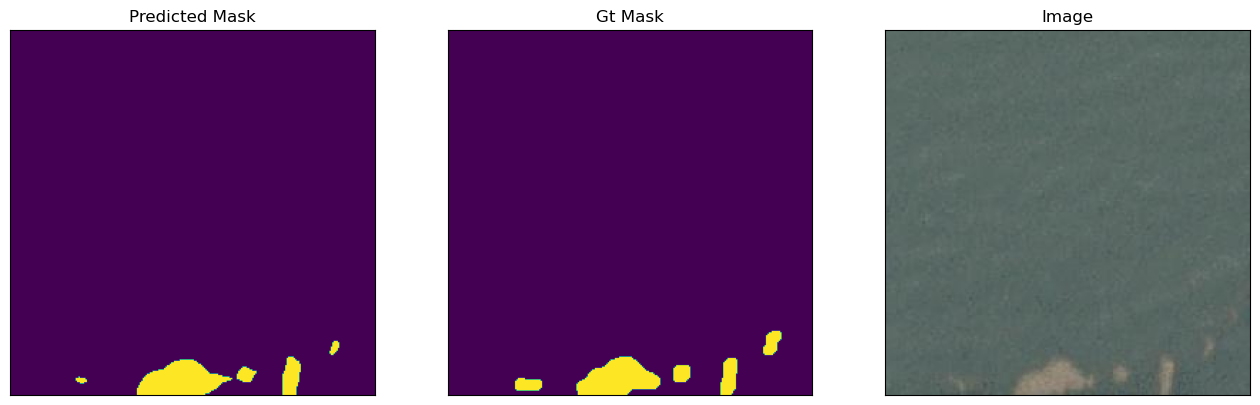

1/1 [==============================] - 0s 235ms/step


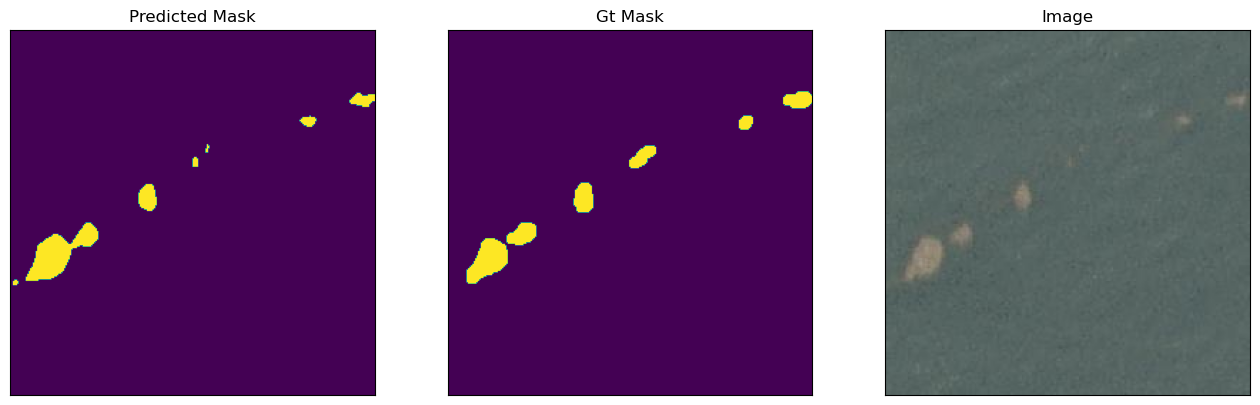

1/1 [==============================] - 0s 246ms/step


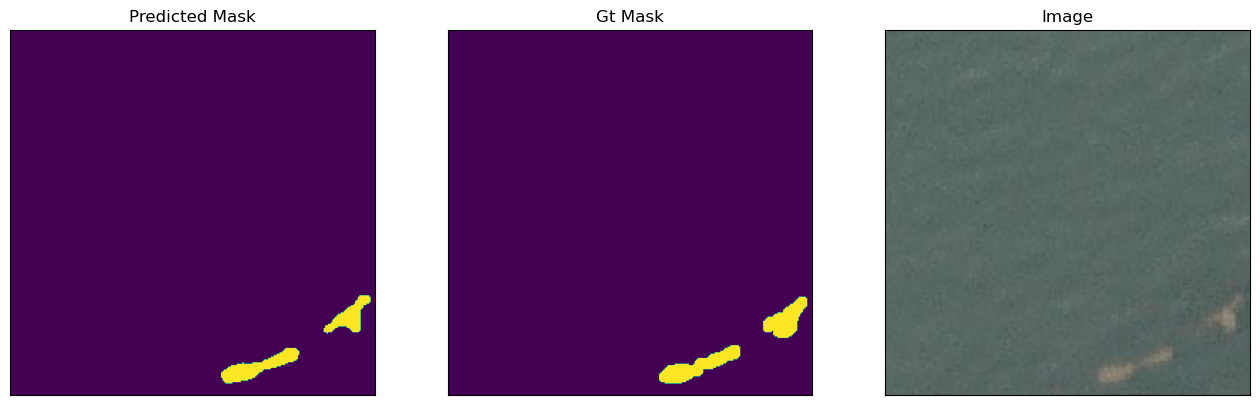

1/1 [==============================] - 0s 238ms/step


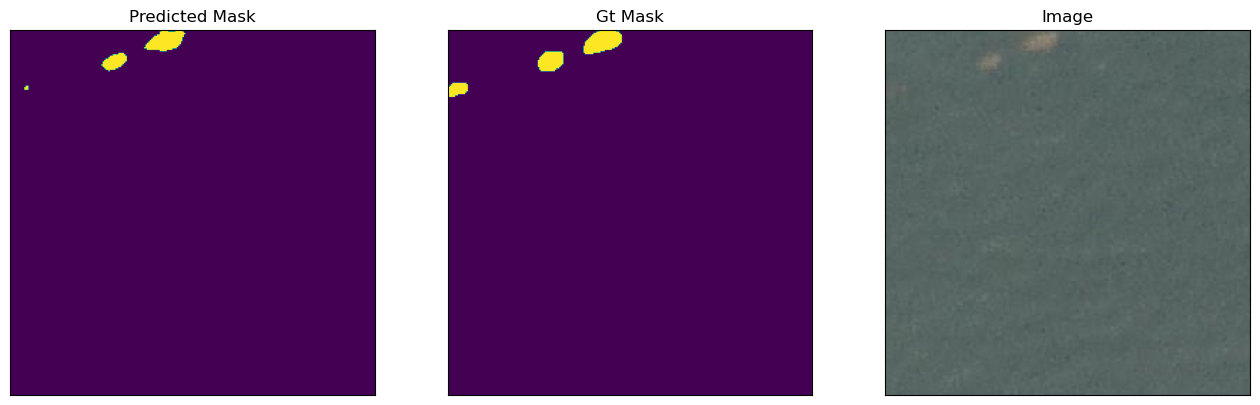

1/1 [==============================] - 0s 256ms/step


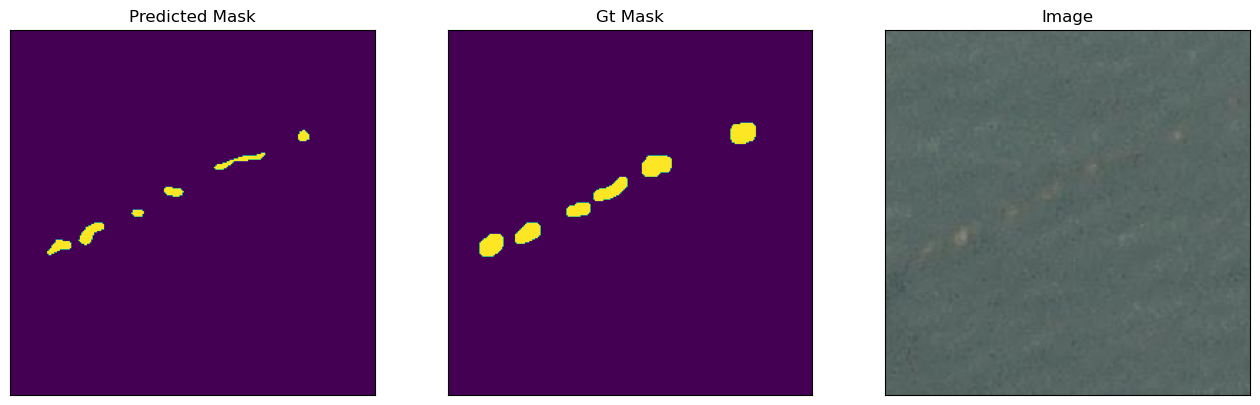

1/1 [==============================] - 0s 244ms/step


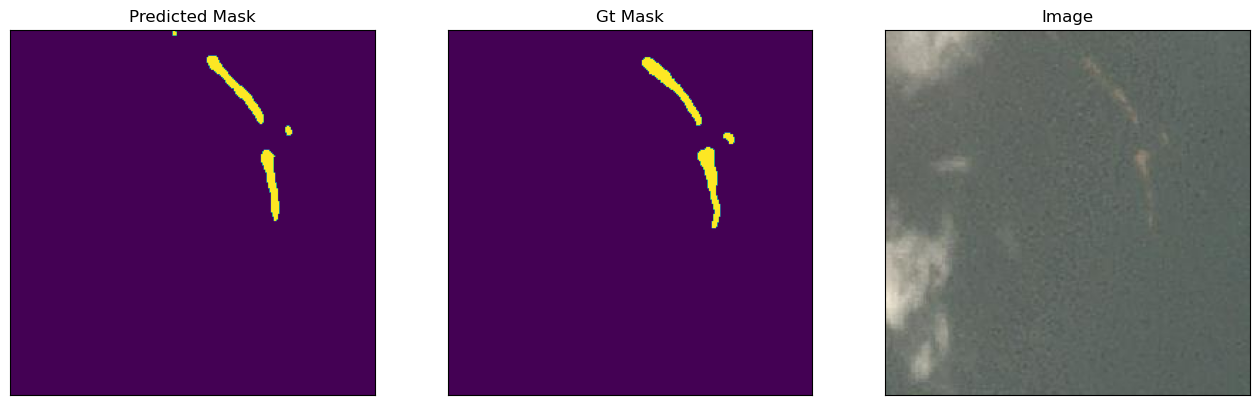

1/1 [==============================] - 0s 248ms/step


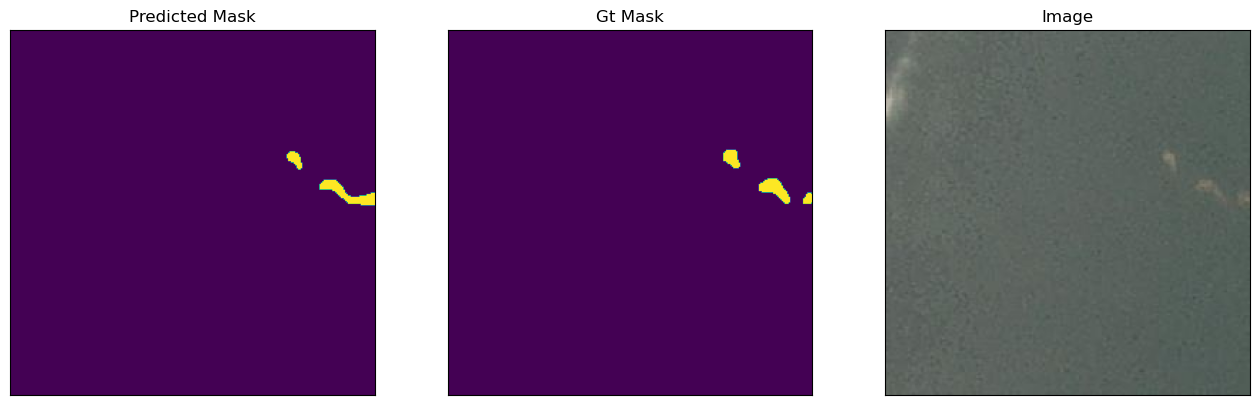

1/1 [==============================] - 0s 239ms/step


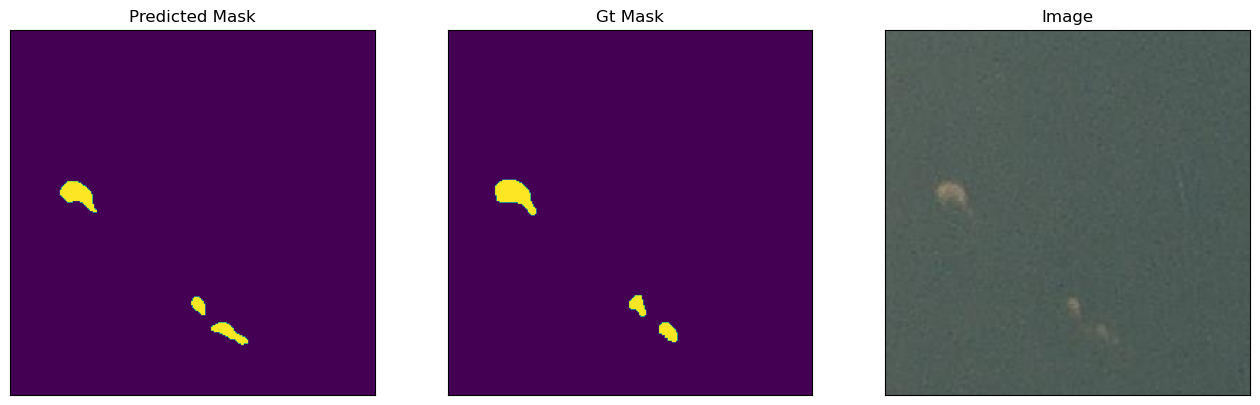

1/1 [==============================] - 0s 238ms/step


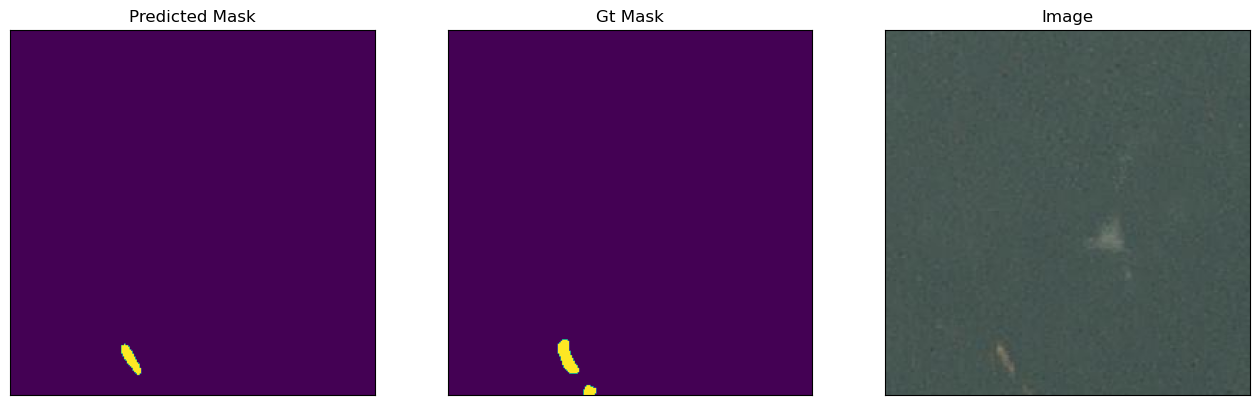

1/1 [==============================] - 0s 240ms/step


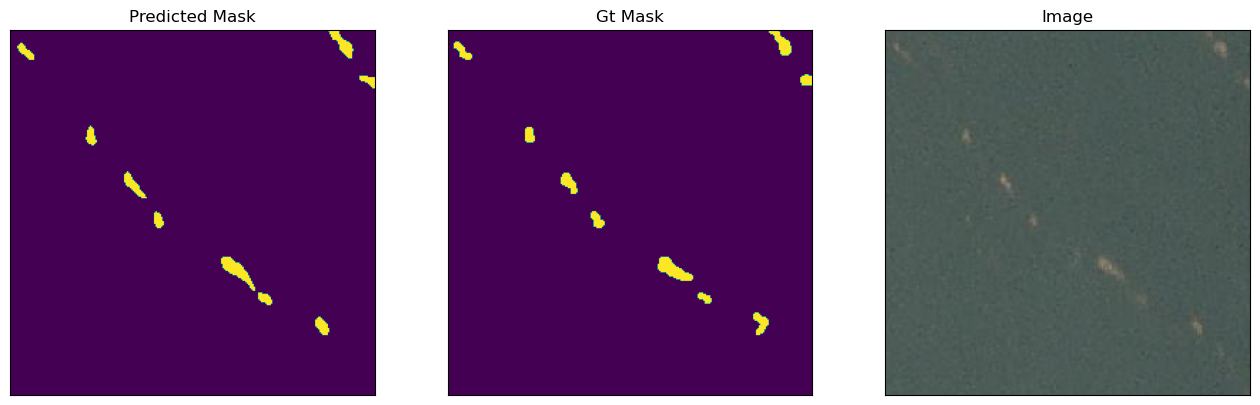

1/1 [==============================] - 0s 229ms/step


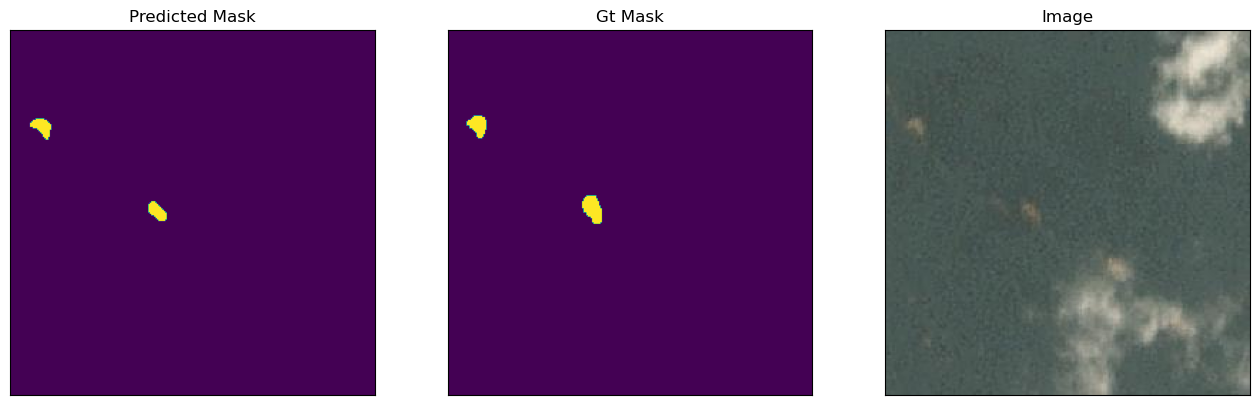

1/1 [==============================] - 0s 234ms/step


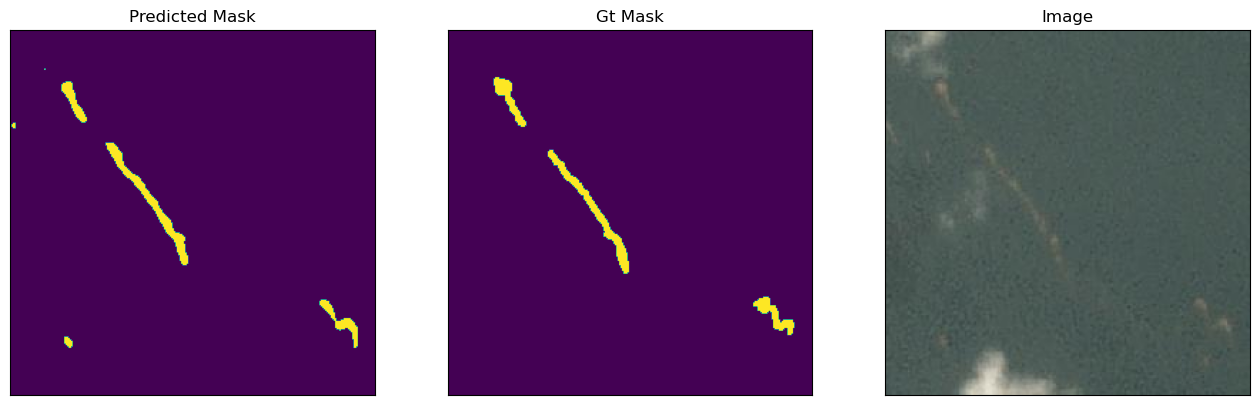

1/1 [==============================] - 0s 221ms/step


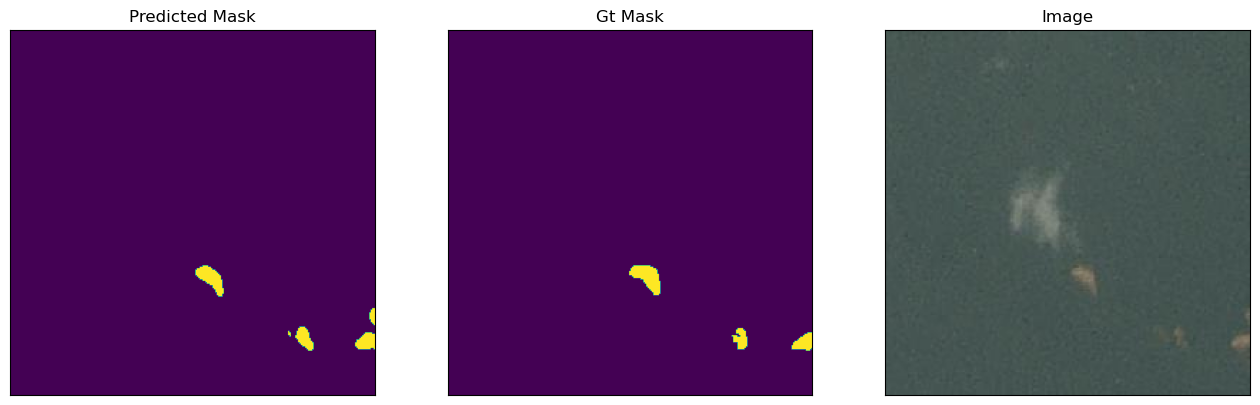

1/1 [==============================] - 0s 267ms/step


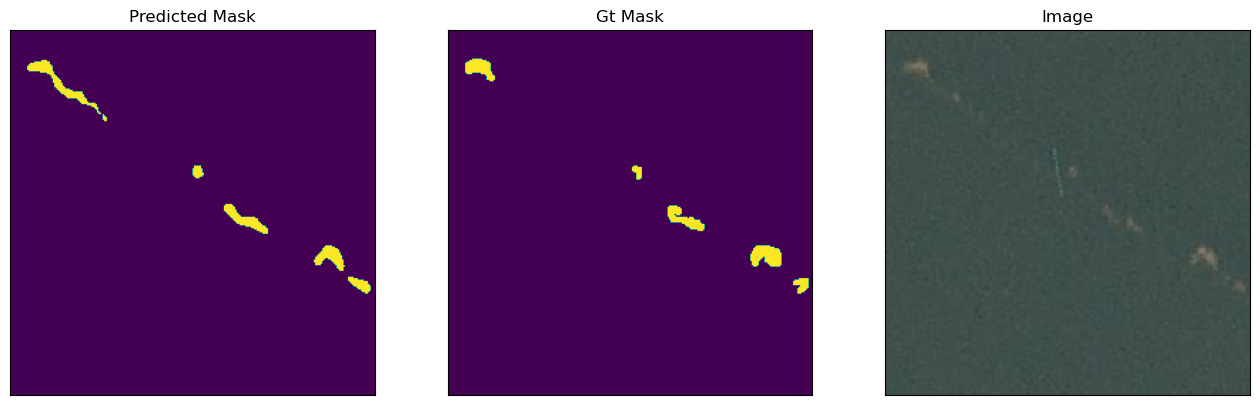

1/1 [==============================] - 0s 235ms/step


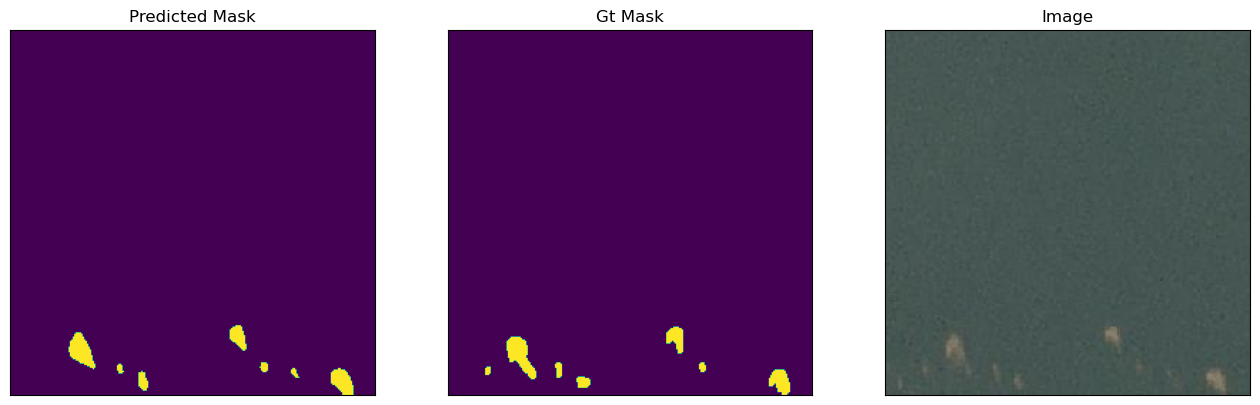

1/1 [==============================] - 0s 218ms/step


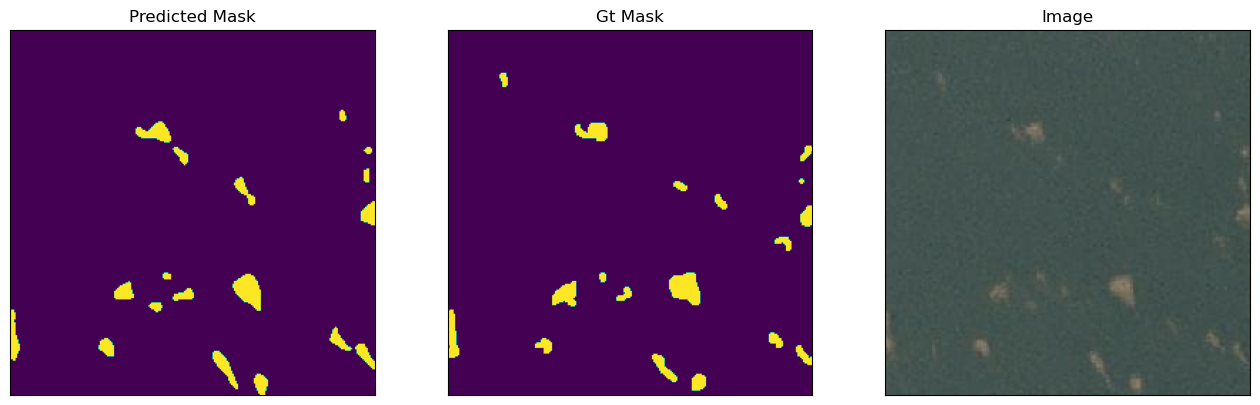

1/1 [==============================] - 0s 229ms/step


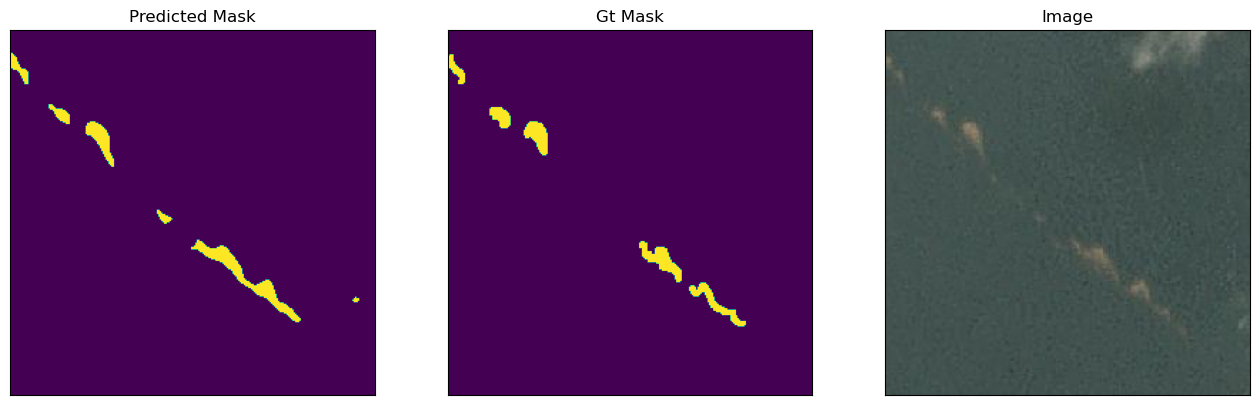

1/1 [==============================] - 0s 219ms/step


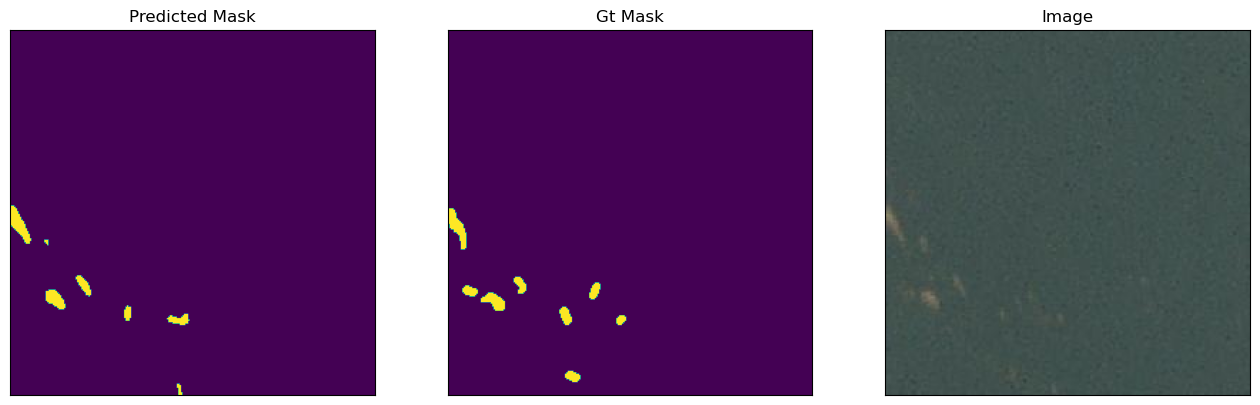

1/1 [==============================] - 0s 221ms/step


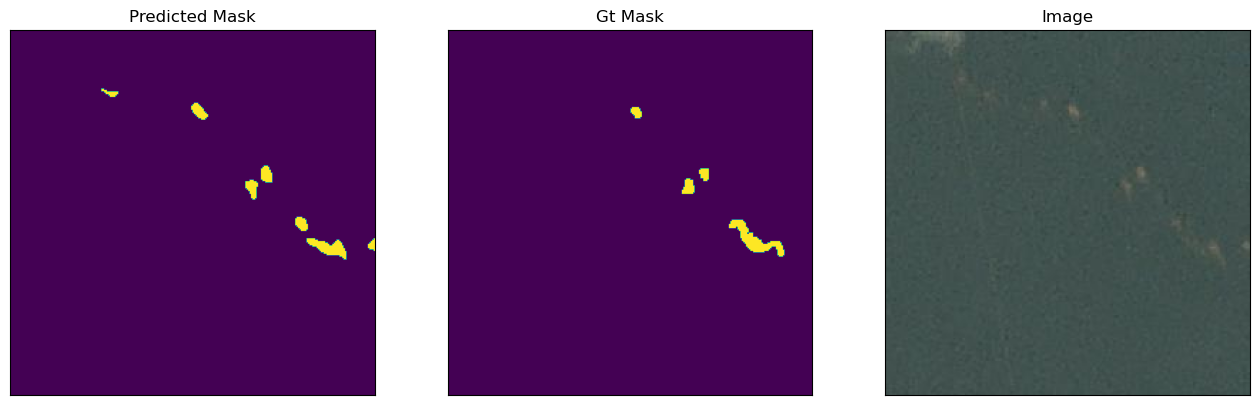

1/1 [==============================] - 0s 218ms/step


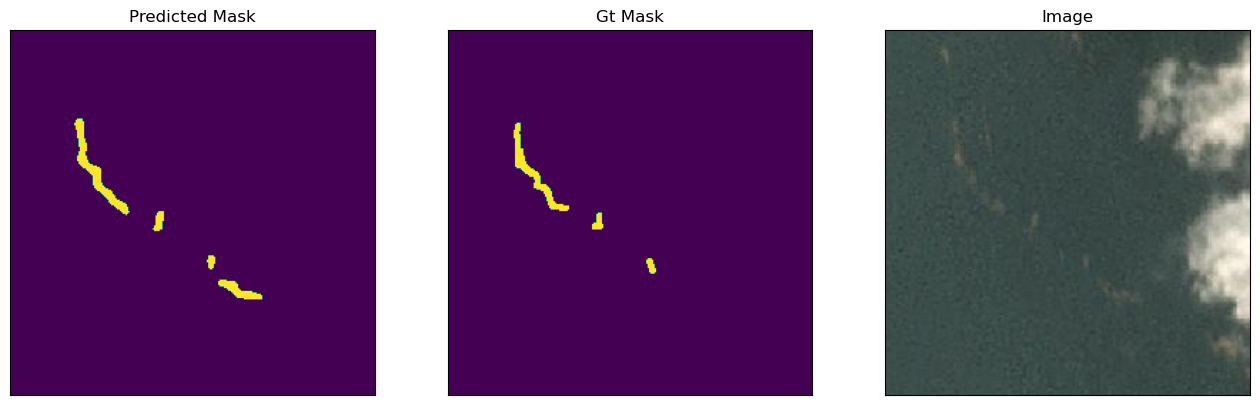

1/1 [==============================] - 0s 233ms/step


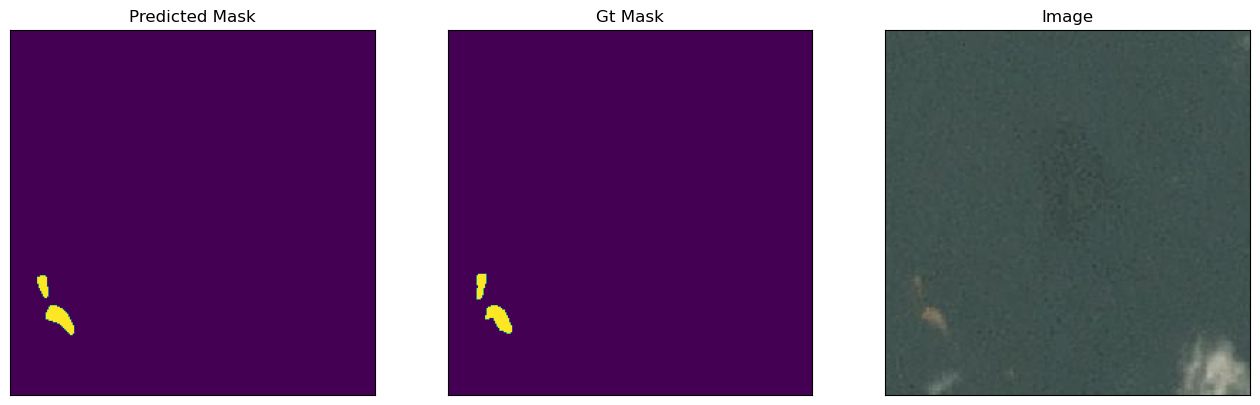

1/1 [==============================] - 0s 229ms/step


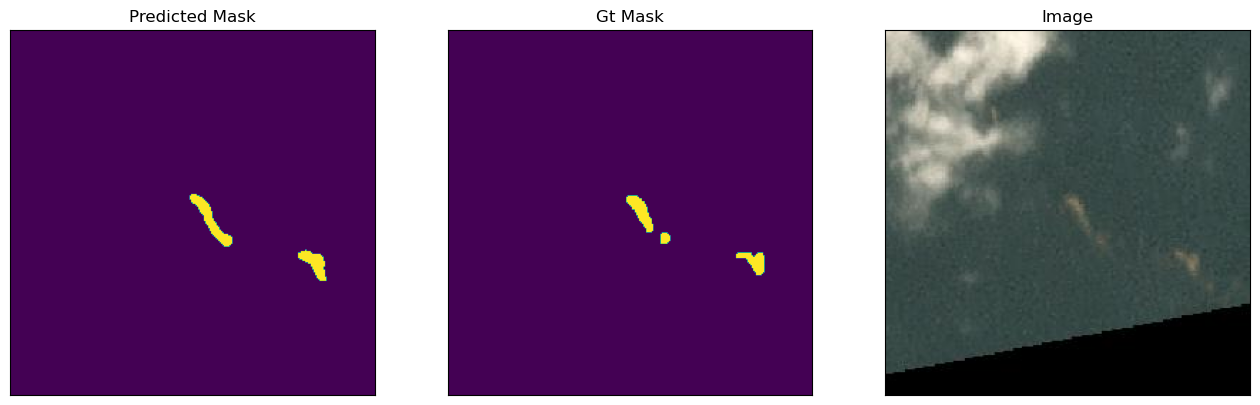

1/1 [==============================] - 0s 222ms/step


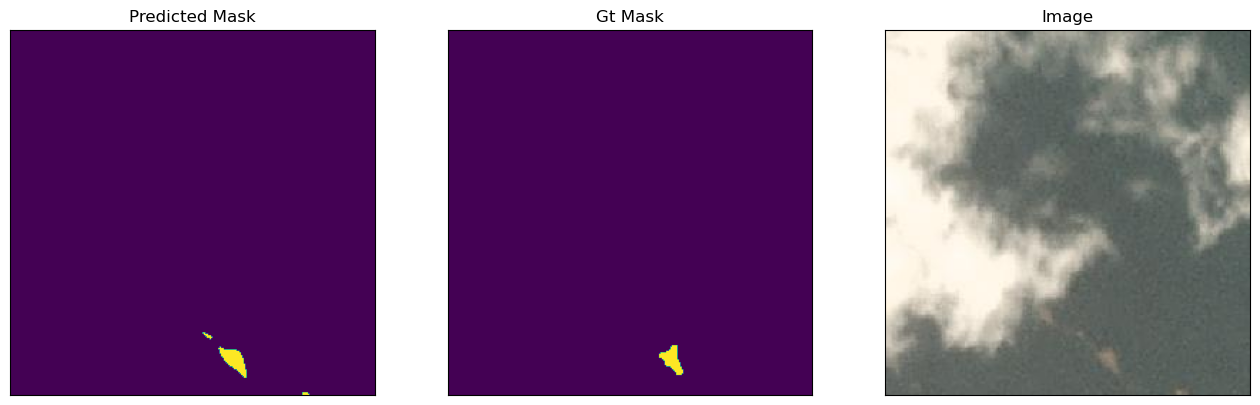

1/1 [==============================] - 0s 228ms/step


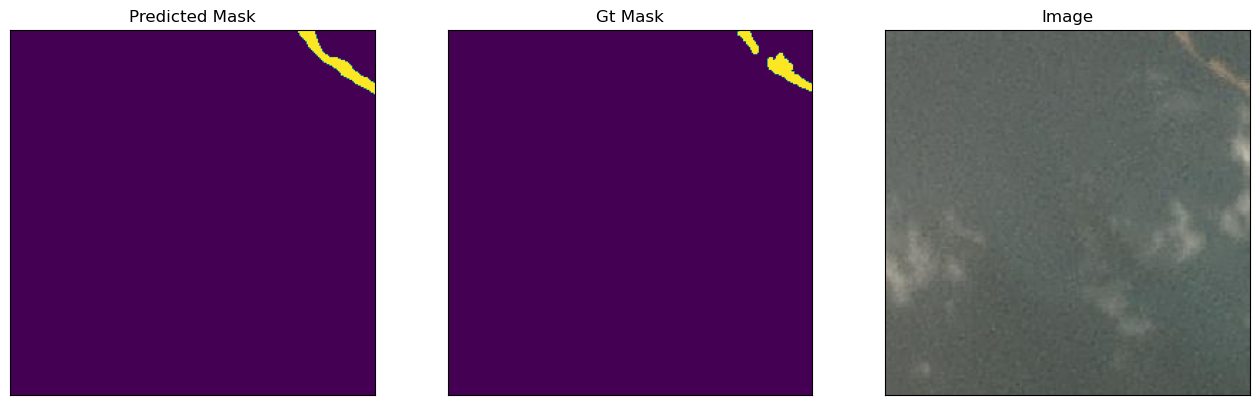

1/1 [==============================] - 0s 225ms/step


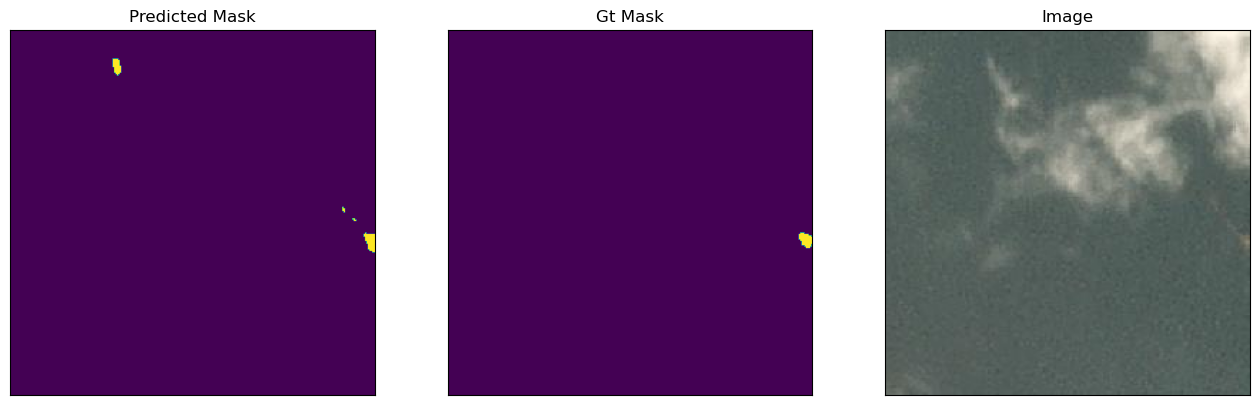

1/1 [==============================] - 0s 243ms/step


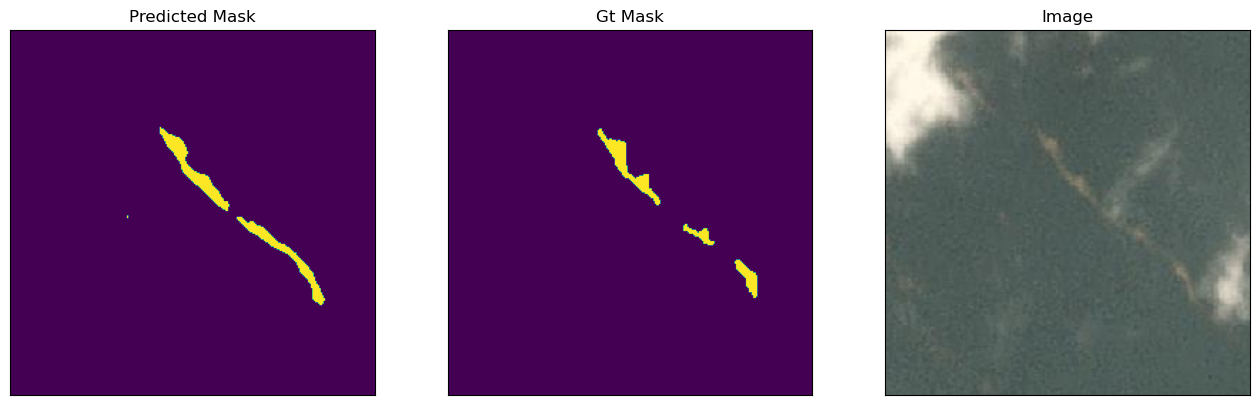

1/1 [==============================] - 0s 235ms/step


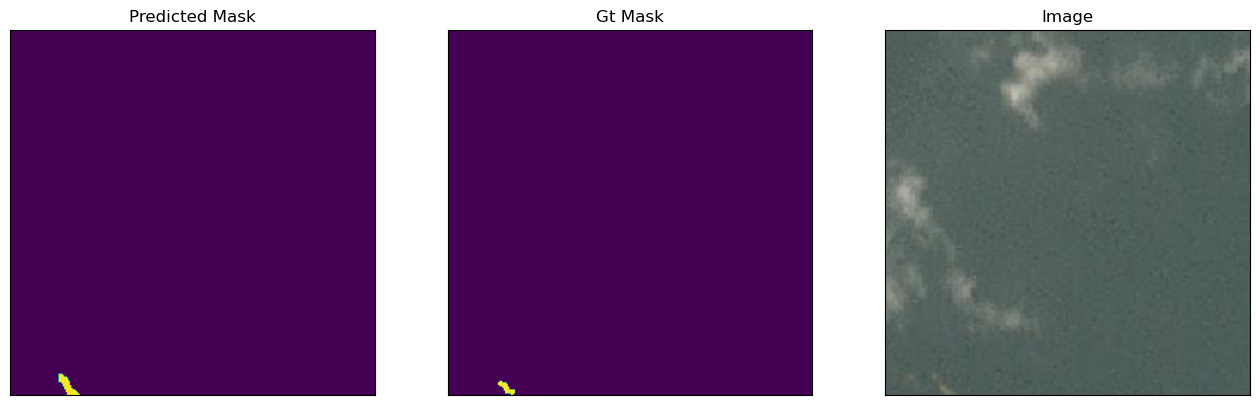

1/1 [==============================] - 0s 251ms/step


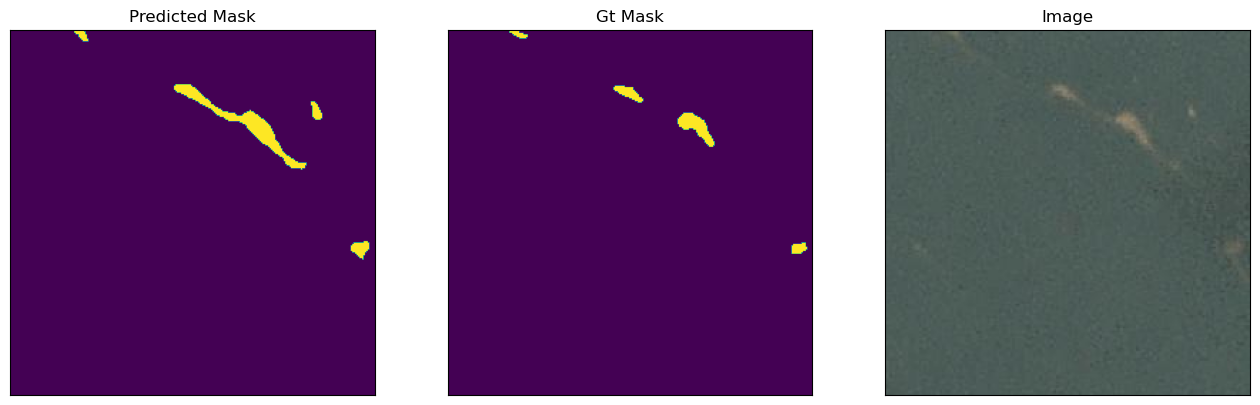

1/1 [==============================] - 0s 224ms/step


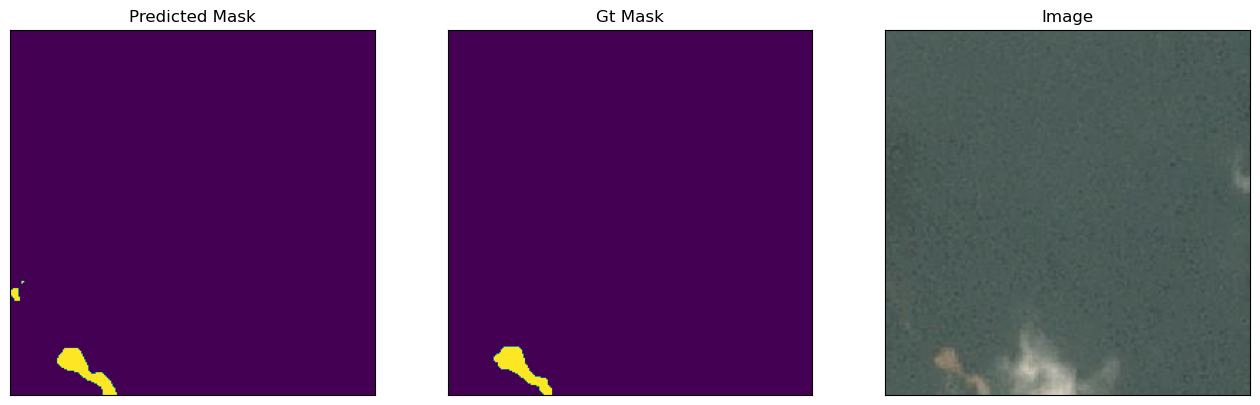

1/1 [==============================] - 0s 246ms/step


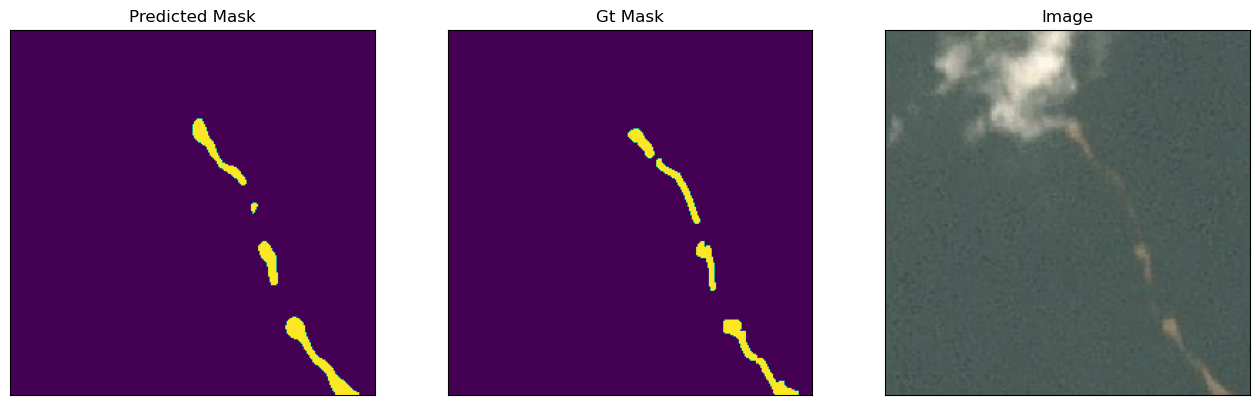

1/1 [==============================] - 0s 219ms/step


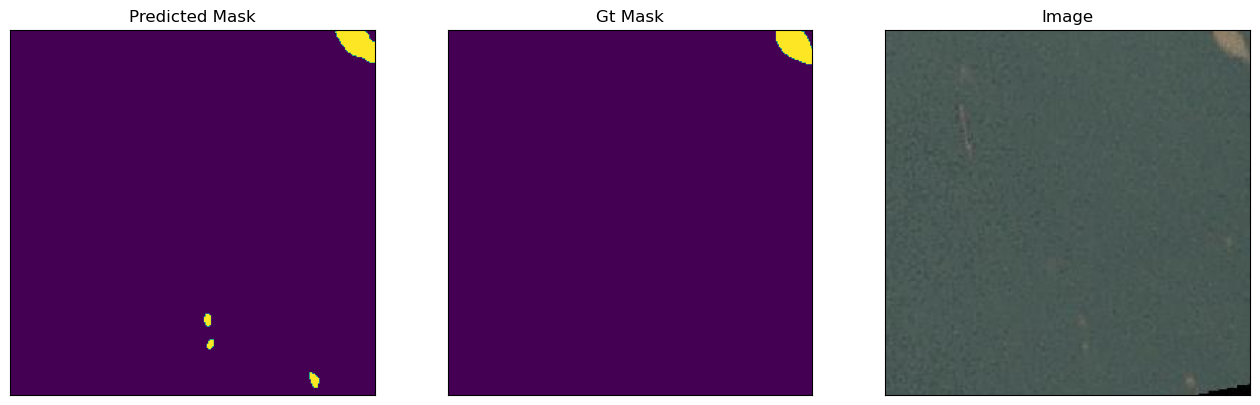

1/1 [==============================] - 0s 218ms/step


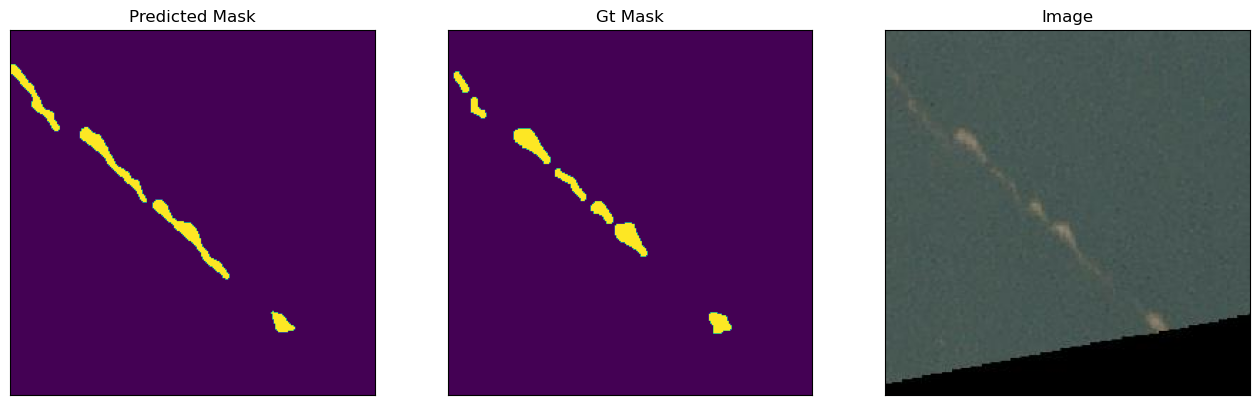

1/1 [==============================] - 0s 234ms/step


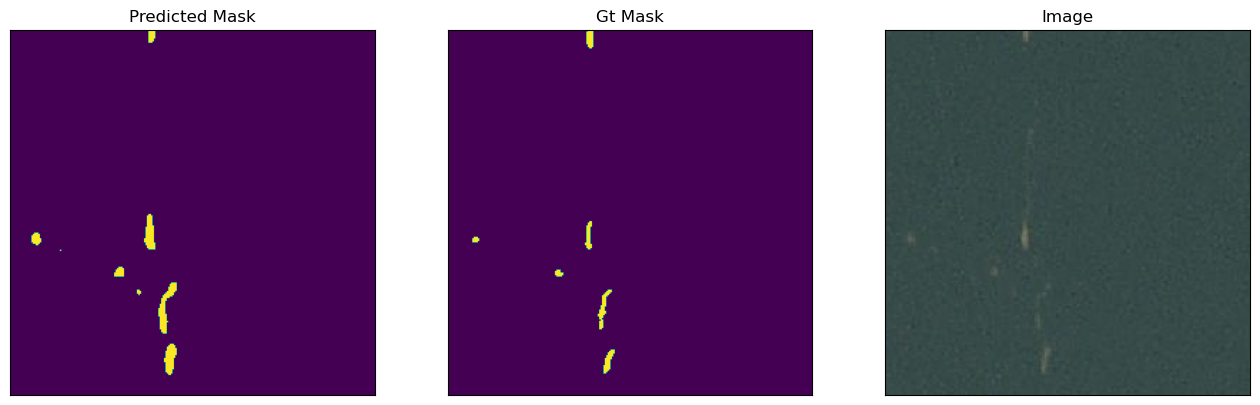

1/1 [==============================] - 0s 220ms/step


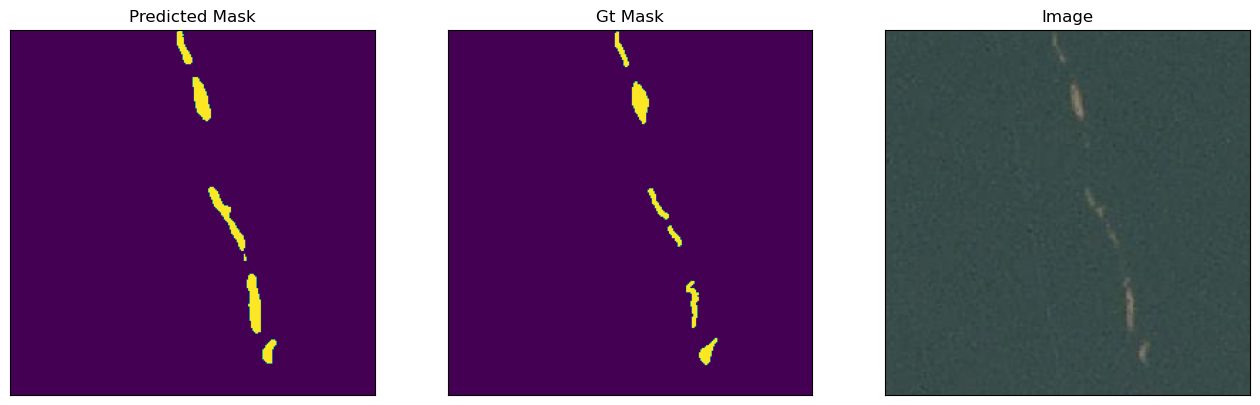

1/1 [==============================] - 0s 229ms/step


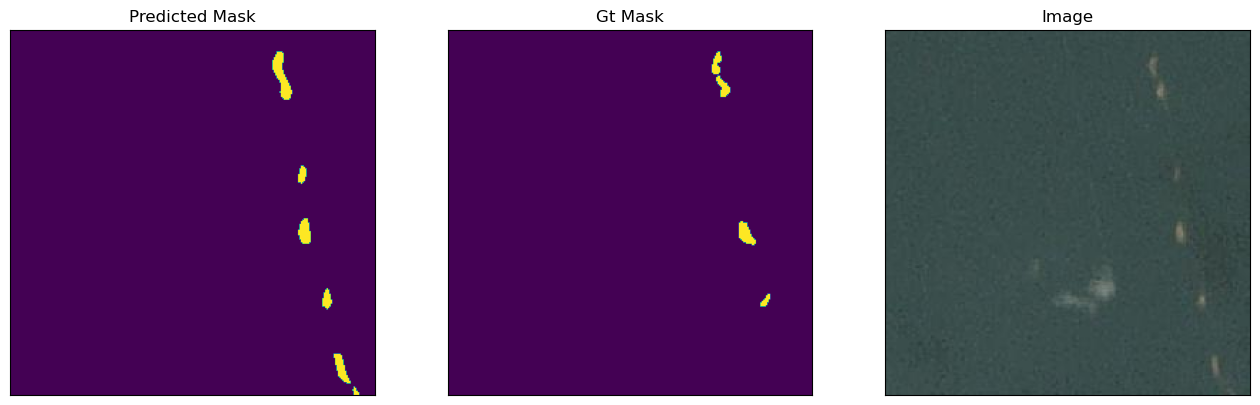

1/1 [==============================] - 0s 228ms/step


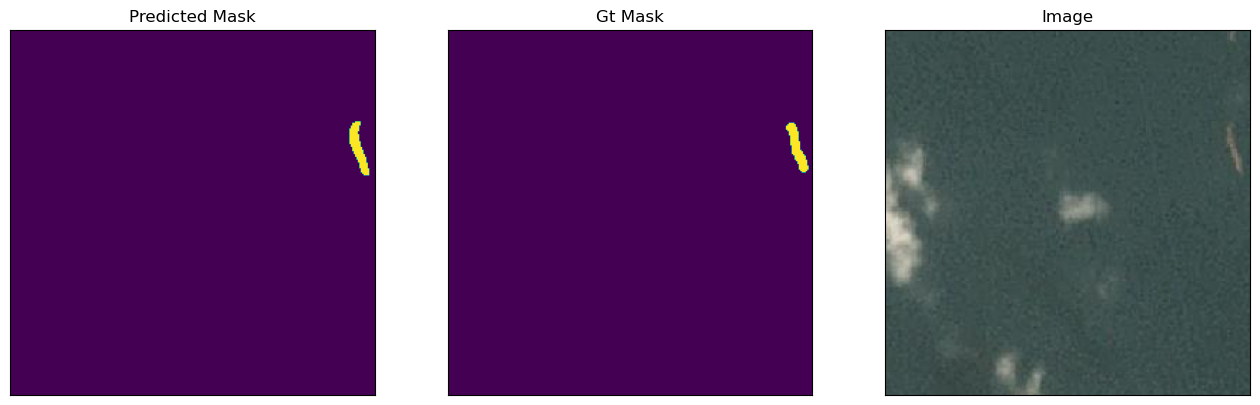

1/1 [==============================] - 0s 226ms/step


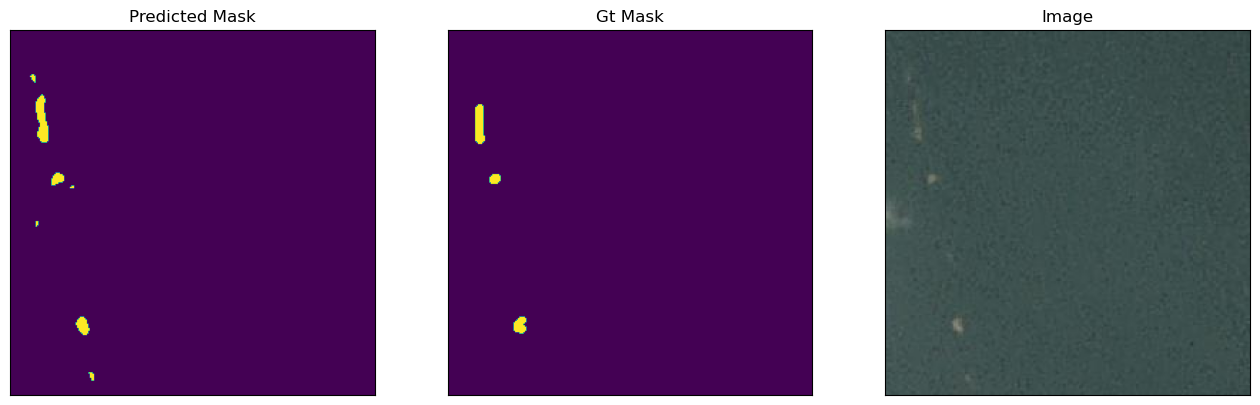

1/1 [==============================] - 0s 218ms/step


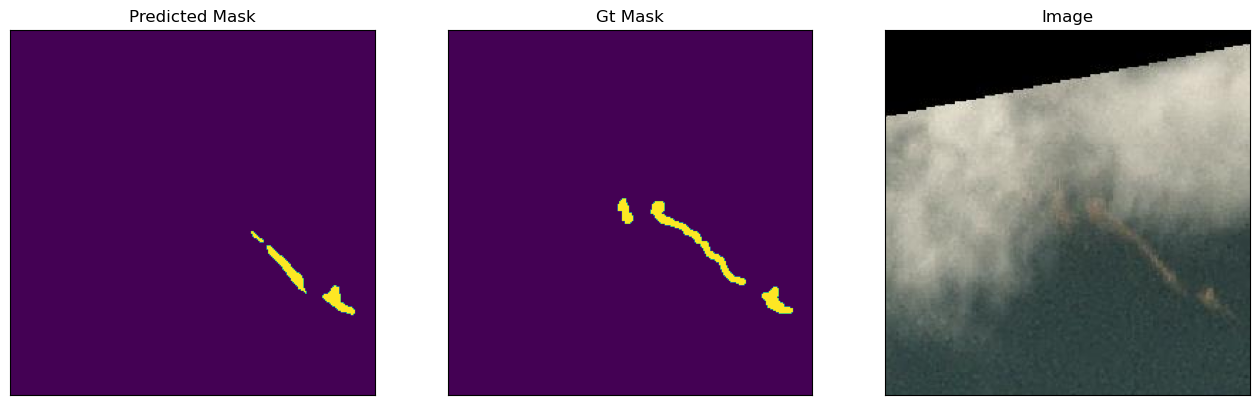

1/1 [==============================] - 0s 239ms/step


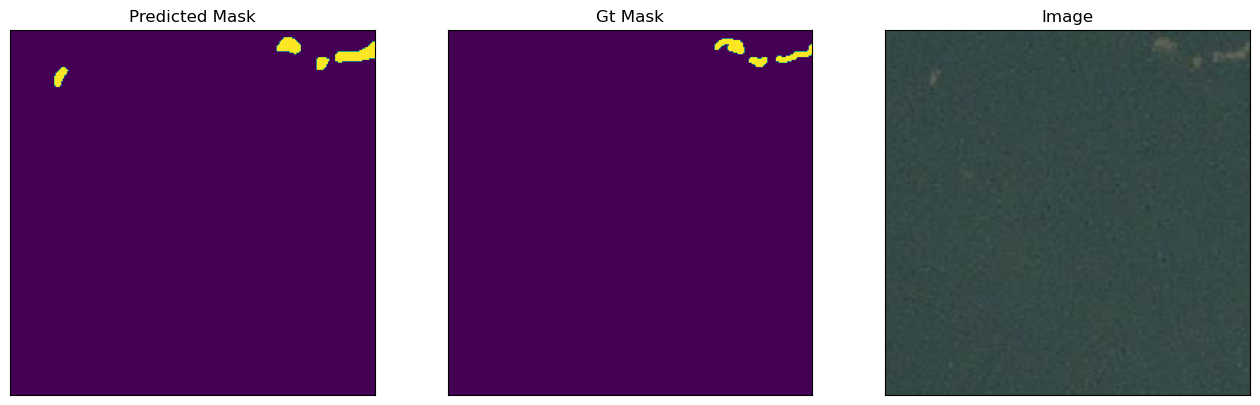

1/1 [==============================] - 0s 229ms/step


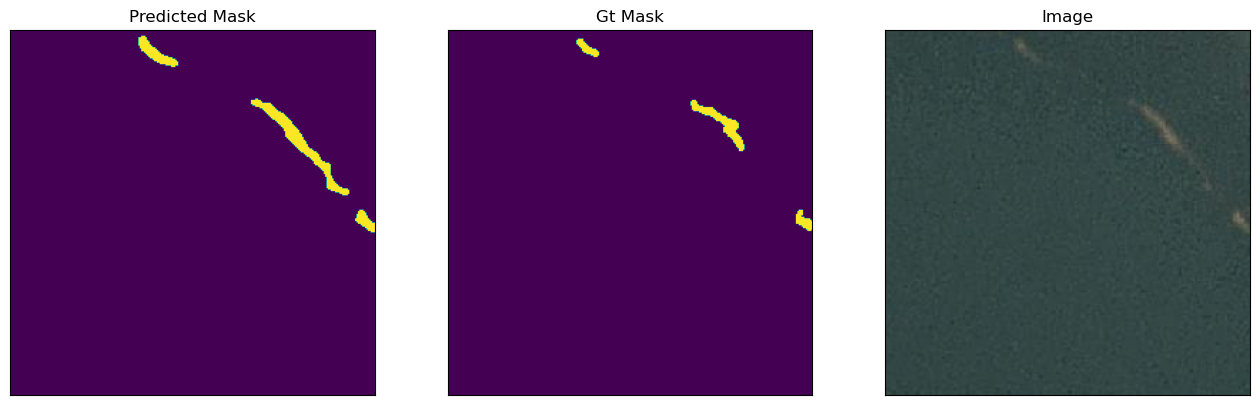

1/1 [==============================] - 0s 225ms/step


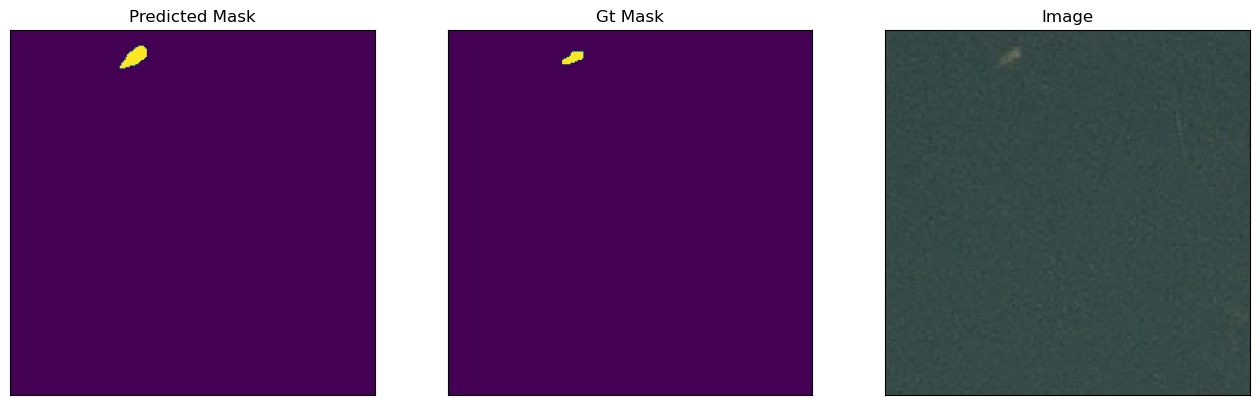

1/1 [==============================] - 0s 219ms/step


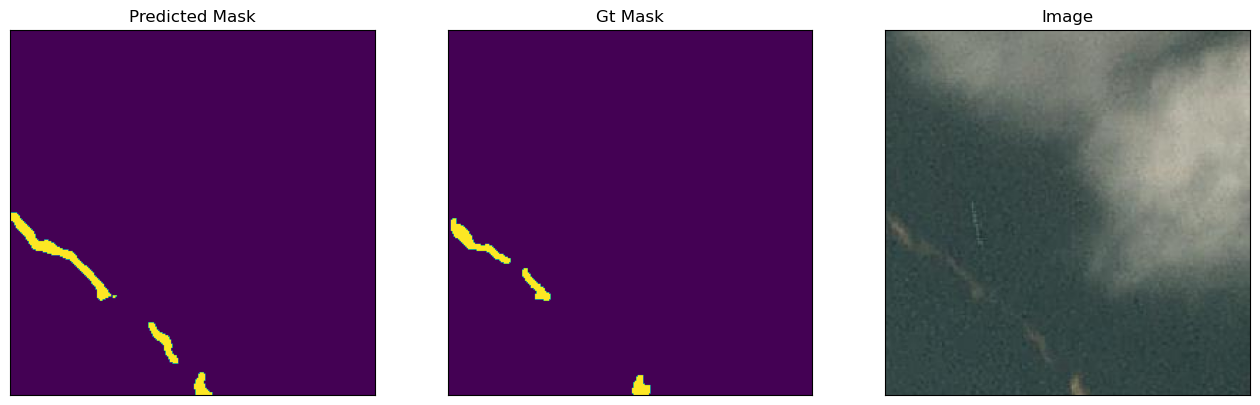

1/1 [==============================] - 0s 247ms/step


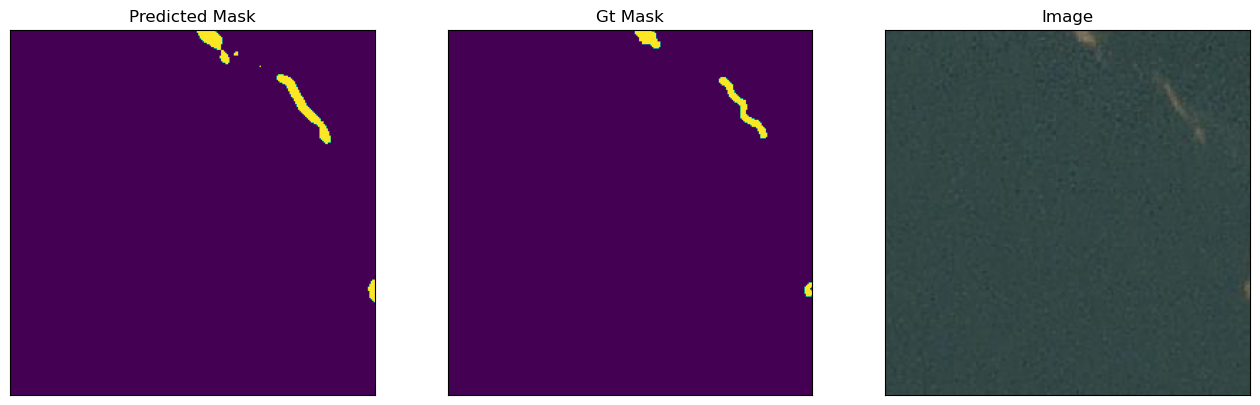

1/1 [==============================] - 0s 220ms/step


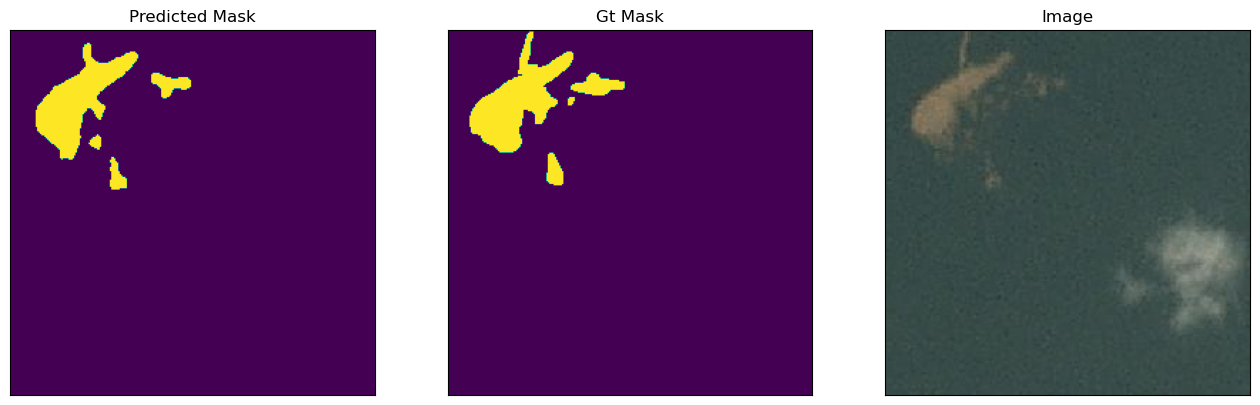

1/1 [==============================] - 0s 255ms/step


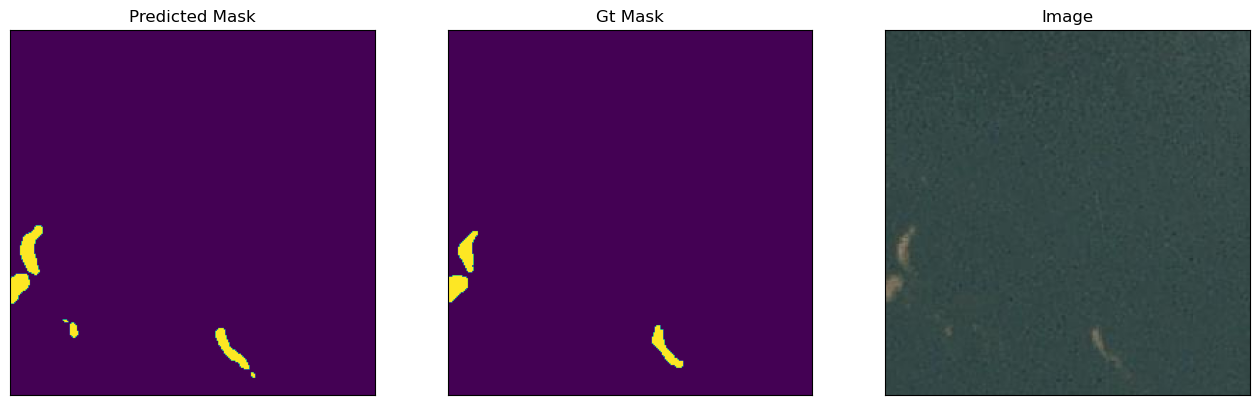

1/1 [==============================] - 0s 219ms/step


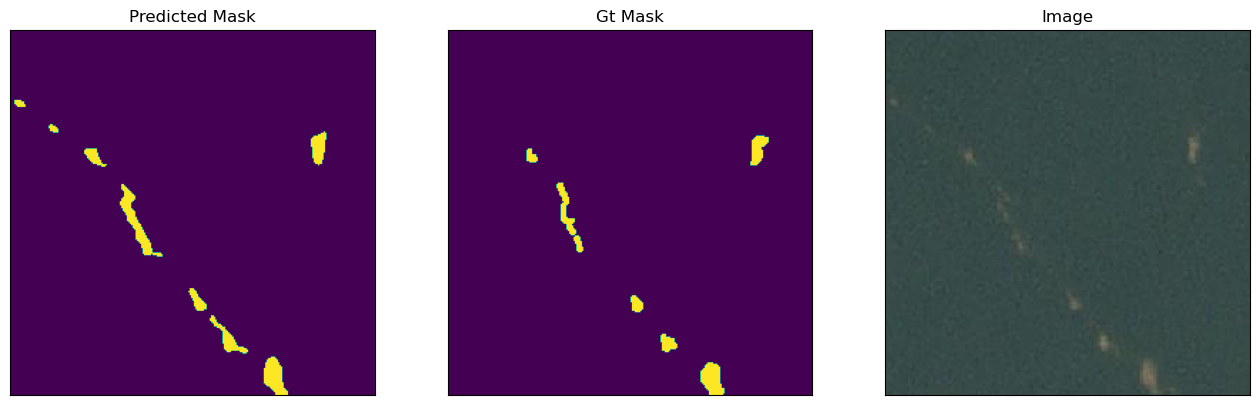

1/1 [==============================] - 0s 235ms/step


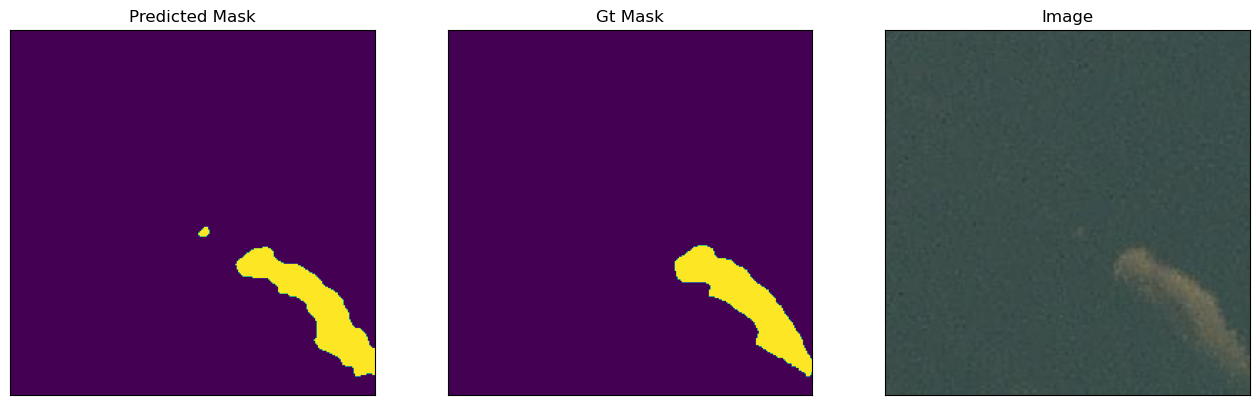

1/1 [==============================] - 0s 230ms/step


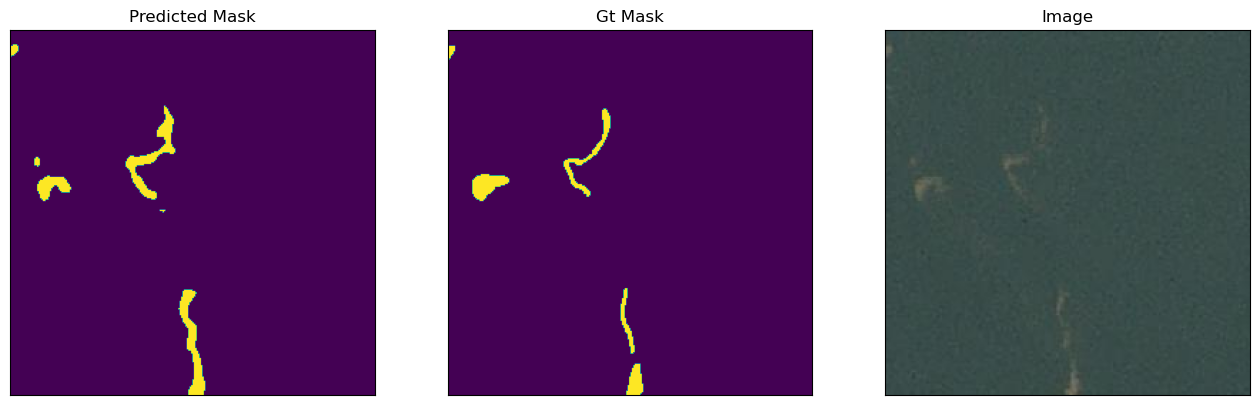

1/1 [==============================] - 0s 228ms/step


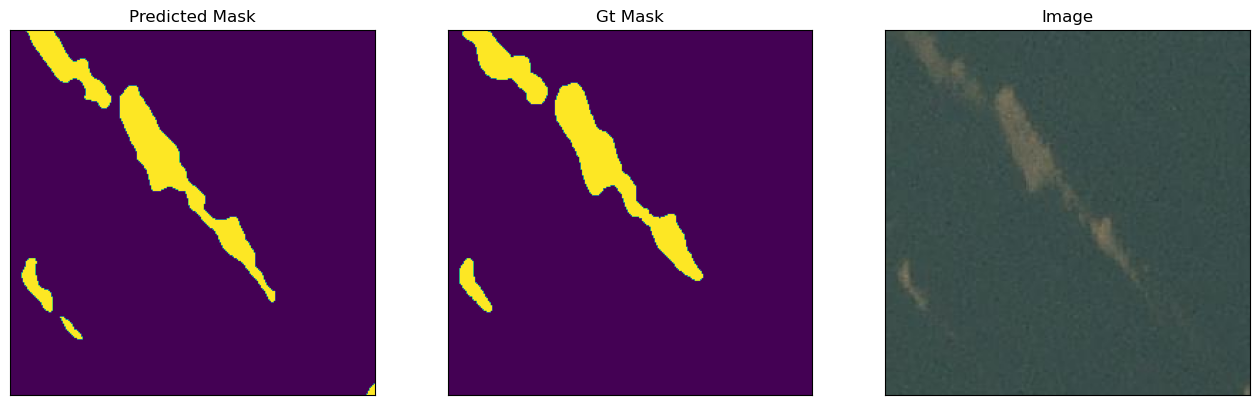

1/1 [==============================] - 0s 228ms/step


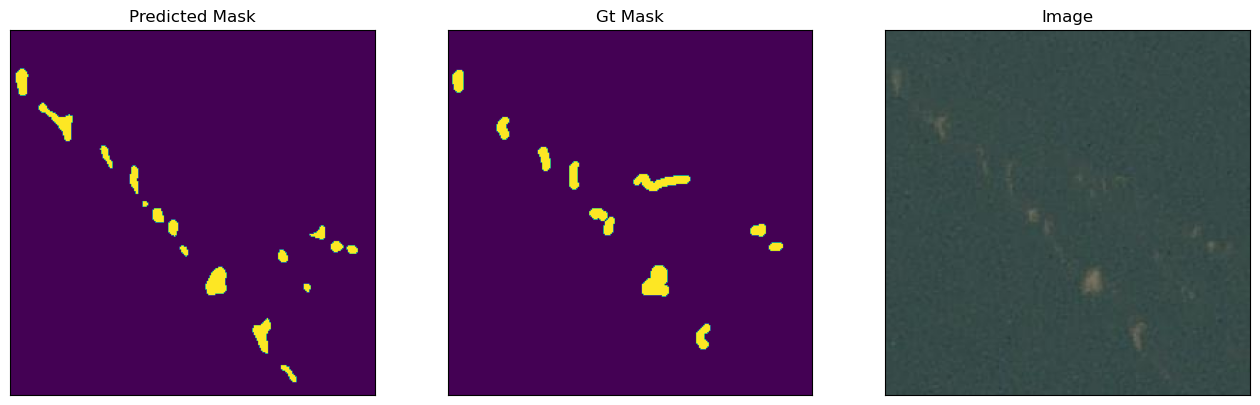

1/1 [==============================] - 0s 224ms/step


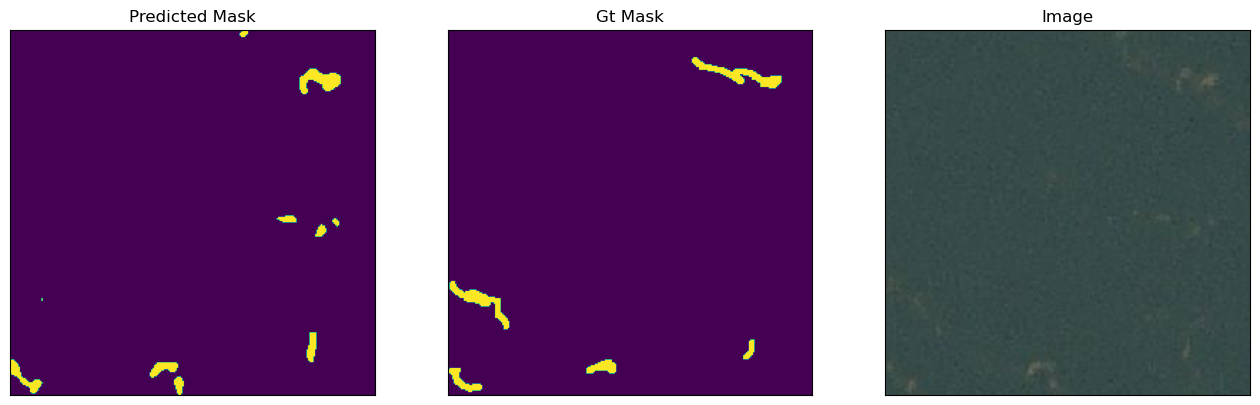

1/1 [==============================] - 0s 238ms/step


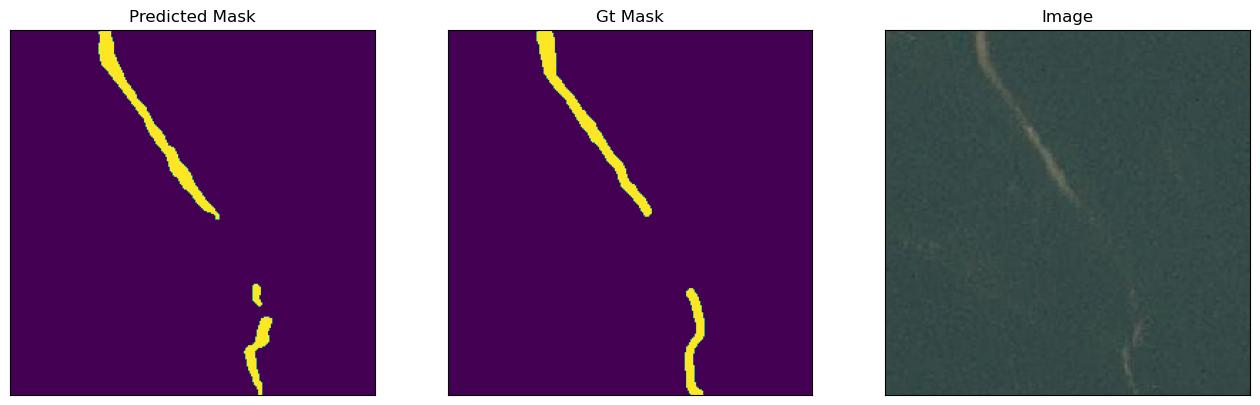

1/1 [==============================] - 0s 232ms/step


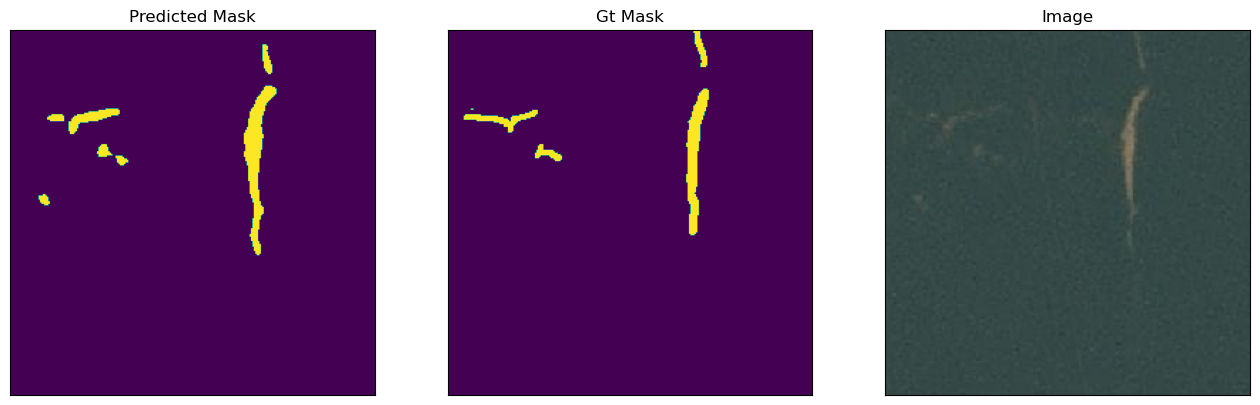

1/1 [==============================] - 0s 241ms/step


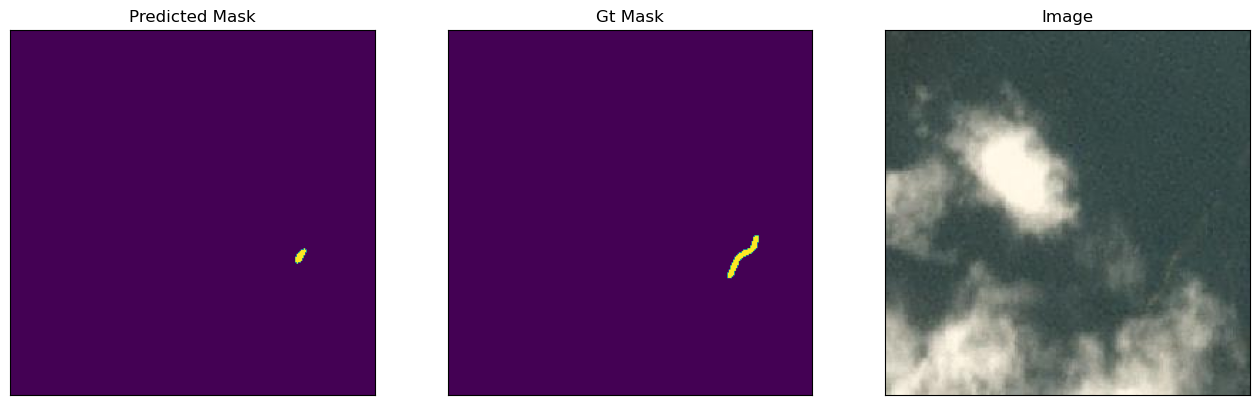

1/1 [==============================] - 0s 230ms/step


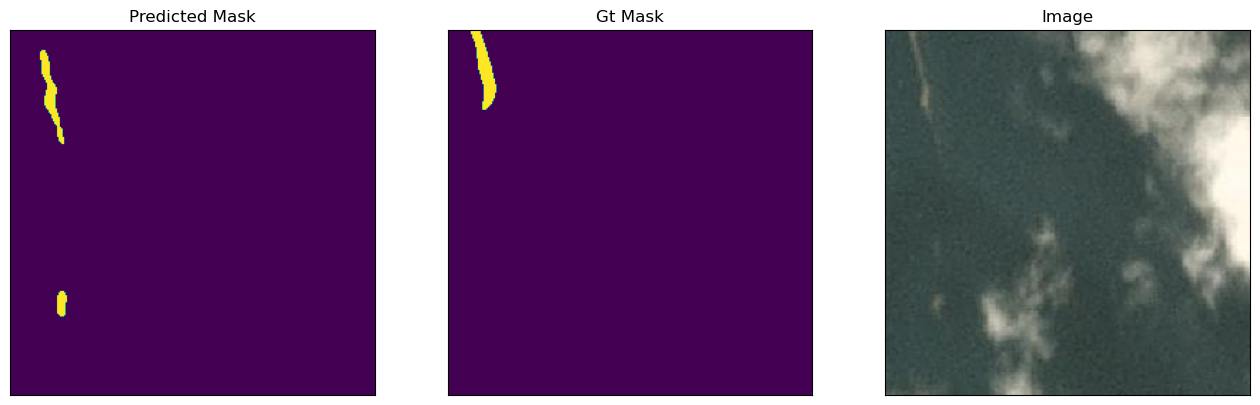

1/1 [==============================] - 0s 223ms/step


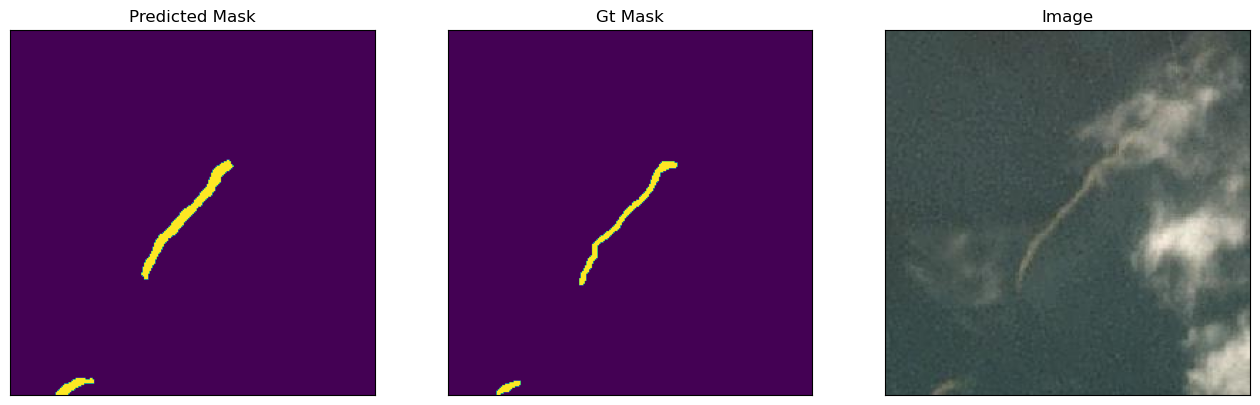

1/1 [==============================] - 0s 240ms/step


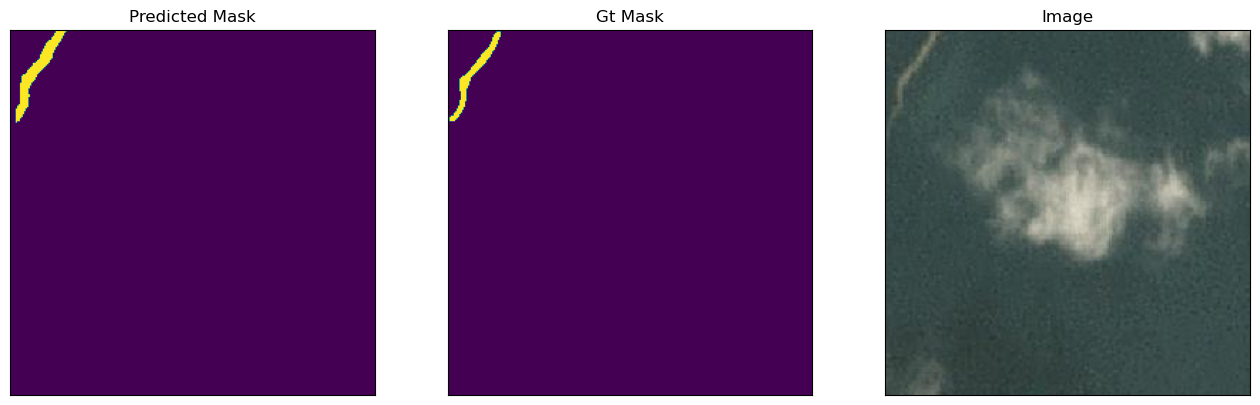

1/1 [==============================] - 0s 234ms/step


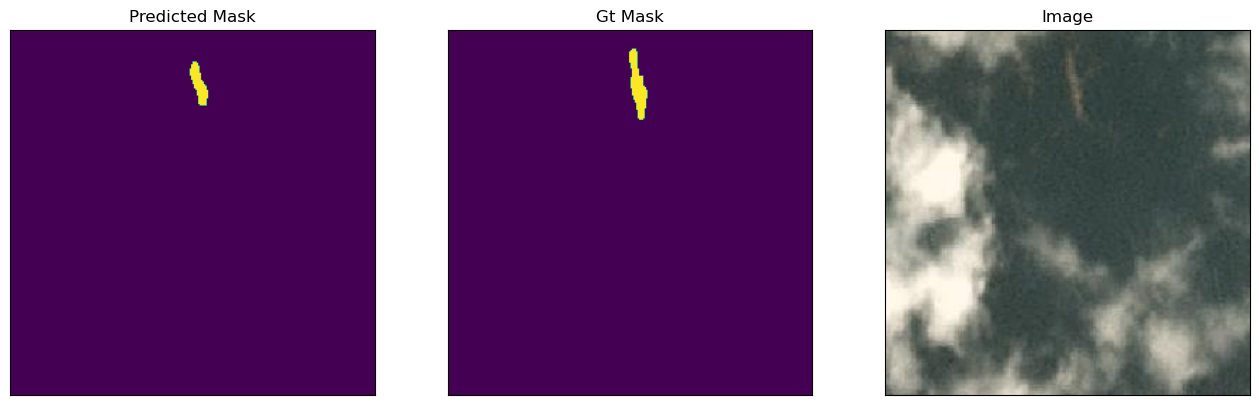

1/1 [==============================] - 0s 236ms/step


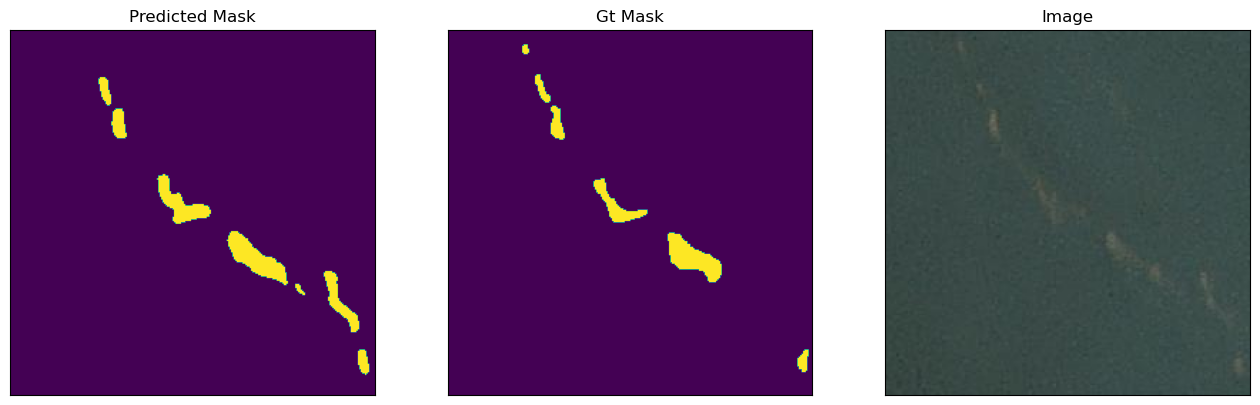

In [12]:
with tf.device('/GPU:0'):
    # checking predictions for best model
    for i in range(len(test_images)):
      prediction = predict(model_efficientnetb4_v2, test_images[i])
      visualize(
          predicted_mask=prediction,
          gt_mask=test_masks[i],
          image=test_images[i]
      )